# PRO X GAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import skimage.transform
from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls
import os

import warnings
warnings.filterwarnings('ignore')

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: N

In [2]:
gpus = tf.config.list_physical_devices("GPU") 
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-01-04 00:38:57.228731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 00:38:57.233574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 00:38:57.233785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()

couldn't import doomish
Couldn't import doom


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_

In [4]:
path = './movie_f' 
if not os.path.exists(path):
    os.makedirs(path)

In [5]:
hparas = {
    'image_size': 84,
    'num_stack': 4,
    'action_dim': len(env.getActionSet()),
    'hidden_size': 256,
    'lr': 0.0001,
    'gamma': 0.99,
    'lambda': 0.95,
    'clip_val': 0.2,
    'ppo_epochs': 8,
    'test_epochs': 1,
    'num_steps': 512,
    'mini_batch_size': 64,
    'target_reward': 200,
    'max_episode': 30000,
}

In [6]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    
    return clip

In [7]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(screen, [hparas['image_size'], hparas['image_size'], 1])
    return screen.astype(np.float32)

def frames_to_state(input_frames):
    if(len(input_frames) == 1):
        state = np.concatenate(input_frames*4, axis=-1)
    elif(len(input_frames) == 2):
        state = np.concatenate(input_frames[0:1]*2 + input_frames[1:]*2, axis=-1)
    elif(len(input_frames) == 3):
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state

In [8]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential([
          # Convolutional Layers
          tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
          tf.keras.layers.ReLU(),
          # Embedding Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(hparas['hidden_size']),
          tf.keras.layers.ReLU(),
        ])

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas['action_dim'], activation='softmax')
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation = None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value

In [9]:
class Agent():
    def __init__(self, hparas):
        self.gamma = hparas['gamma']
        self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hparas['lr'])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas['clip_val']
    
    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32)
            yield tf.gather(states, rand_ids), tf.gather(actions, rand_ids), tf.gather(log_probs, rand_ids), \
             tf.gather(returns, rand_ids), tf.gather(advantage, rand_ids)
    
    def ppo_update(self, ppo_epochs, mini_batch_size, states, actions, log_probs, discount_rewards, advantages):       
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(mini_batch_size, states, actions, log_probs, discount_rewards, advantages):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram) * advantage

                    actor_loss = tf.math.negative(tf.math.reduce_mean(tf.math.minimum(surr1, surr2))) - 0.1 * entropy
                    critic_loss = 0.5 * tf.math.reduce_mean(kls.mean_squared_error(reward, value))

                    total_loss = actor_loss + critic_loss
            
                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_variables))
      
                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss

In [10]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns

## Testing Environment

In [11]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward

## Training

In [12]:
agent = Agent(hparas)
max_episode = hparas['max_episode']
test_per_n_episode = 10
force_save_per_n_episode = 300
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic = agent.actor_critic,
    optimizer = agent.optimizer,
)

# Load from old checkpoint
#checkpoint.restore('./save/checkpoints/ckpt-13')

In [13]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas['num_steps']):

        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1-int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]
  
    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas['gamma'], hparas['lambda'])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(hparas['ppo_epochs'], hparas['mini_batch_size'], states, actions, log_probs, returns, advantage)
    print('[Episode %d]  Actor loss: %.5f, Critic loss: %.5f' % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean([test_reward(test_env, agent) for _ in range(hparas['test_epochs'])])
        print("Test average reward is %.1f, Current best average reward is %.1f\n" % (avg_reward, best_reward))
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
            checkpoint.save(file_prefix = './save/checkpoints/ckpt')

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save('./save/Actor/model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        checkpoint.save(file_prefix = './save/checkpoints/ckpt')
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format('Lab15', s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True

2024-01-04 00:38:59.175898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


[Episode 0]  Actor loss: 91.49503, Critic loss: 63.47803
Test average reward is -5.0, Current best average reward is -5.0

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_0_-5.0/assets


INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_0_-5.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-0.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-0.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1]  Actor loss: 35.01805, Critic loss: 27.48638
[Episode 2]  Actor loss: 28.29596, Critic loss: 22.39470
[Episode 3]  Actor loss: 18.93994, Critic loss: 13.23186
[Episode 4]  Actor loss: 18.83661, Critic loss: 9.59441
[Episode 5]  Actor loss: 14.95750, Critic loss: 6.98318
[Episode 6]  Actor loss: 13.62313, Critic loss: 5.86041
[Episode 7]  Actor loss: 5.38556, Critic loss: 4.53594
[Episode 8]  Actor loss: -2.53787, Critic loss: 3.54281
[Episode 9]  Actor loss: -1.43879, Critic loss: 2.87541
[Episode 10]  Actor loss: 0.14197, Critic loss: 3.52196
Test average reward is -5.0, Current best average reward is -5.0

[Episode 11]  Actor loss: -1.33020, Critic loss: 3.44560
[Episode 12]  Actor loss: -1.22687, Critic loss: 2.52925
[Episode 13]  Actor loss: -3.23987, Critic loss: 3.18442
[Episode 14]  Actor loss: -9.31029, Critic loss: 2.00721
[Episode 15]  Actor loss: -11.20624, Critic loss: 3.93997
[Episode 16]  Actor loss: -7.89243, Critic loss: 2.39137
[Episode 17]  Actor loss: -7.

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_70_-4.0/assets


[Episode 71]  Actor loss: -3.91397, Critic loss: 1.50061
[Episode 72]  Actor loss: 0.04015, Critic loss: 1.02093
[Episode 73]  Actor loss: 2.86336, Critic loss: 0.71286
[Episode 74]  Actor loss: -4.40672, Critic loss: 0.44036
[Episode 75]  Actor loss: -0.98582, Critic loss: 0.75602
[Episode 76]  Actor loss: -4.28324, Critic loss: 0.60562
[Episode 77]  Actor loss: -0.61031, Critic loss: 1.42213
[Episode 78]  Actor loss: -2.48288, Critic loss: 0.66196
[Episode 79]  Actor loss: -5.97541, Critic loss: 0.67202
[Episode 80]  Actor loss: -5.39416, Critic loss: 0.42756
Test average reward is -5.0, Current best average reward is -4.0

[Episode 81]  Actor loss: -6.03909, Critic loss: 0.55673
[Episode 82]  Actor loss: -5.91885, Critic loss: 0.57460
[Episode 83]  Actor loss: -3.37411, Critic loss: 0.74229
[Episode 84]  Actor loss: -2.69845, Critic loss: 0.73671
[Episode 85]  Actor loss: -2.42598, Critic loss: 0.88392
[Episode 86]  Actor loss: -7.96879, Critic loss: 0.51377
[Episode 87]  Actor loss

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_300_-5.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-300.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-300.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-300.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 301]  Actor loss: -0.95314, Critic loss: 0.33800
[Episode 302]  Actor loss: -4.59907, Critic loss: 0.34307
[Episode 303]  Actor loss: -7.40174, Critic loss: 0.42715
[Episode 304]  Actor loss: -6.38793, Critic loss: 0.25736
[Episode 305]  Actor loss: -5.26853, Critic loss: 0.84759
[Episode 306]  Actor loss: -5.20557, Critic loss: 0.31026
[Episode 307]  Actor loss: -5.45447, Critic loss: 0.33324
[Episode 308]  Actor loss: -1.56953, Critic loss: 0.40896
[Episode 309]  Actor loss: -6.59722, Critic loss: 0.31497
[Episode 310]  Actor loss: -4.74202, Critic loss: 0.35046
Test average reward is -5.0, Current best average reward is -4.0

[Episode 311]  Actor loss: -0.54990, Critic loss: 0.59180
[Episode 312]  Actor loss: -5.31536, Critic loss: 0.45092
[Episode 313]  Actor loss: -6.34445, Critic loss: 0.30268
[Episode 314]  Actor loss: -2.75647, Critic loss: 0.24628
[Episode 315]  Actor loss: -3.61626, Critic loss: 0.20007
[Episode 316]  Actor loss: -5.34099, Critic loss: 0.37708
[Episo

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_600_-5.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-600.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-600.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-600.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 601]  Actor loss: -2.10523, Critic loss: 0.28442
[Episode 602]  Actor loss: -3.50301, Critic loss: 0.42291
[Episode 603]  Actor loss: -3.19631, Critic loss: 0.32866
[Episode 604]  Actor loss: -8.17189, Critic loss: 0.55374
[Episode 605]  Actor loss: -7.19771, Critic loss: 0.79404
[Episode 606]  Actor loss: -3.86402, Critic loss: 0.58927
[Episode 607]  Actor loss: -1.79696, Critic loss: 0.41003
[Episode 608]  Actor loss: -0.70027, Critic loss: 0.32801
[Episode 609]  Actor loss: -4.07882, Critic loss: 0.39689
[Episode 610]  Actor loss: -4.08587, Critic loss: 0.32521
Test average reward is -5.0, Current best average reward is -4.0

[Episode 611]  Actor loss: -2.57975, Critic loss: 0.27459
[Episode 612]  Actor loss: -8.01640, Critic loss: 0.58431
[Episode 613]  Actor loss: -4.86199, Critic loss: 0.22384
[Episode 614]  Actor loss: -3.36286, Critic loss: 0.29600
[Episode 615]  Actor loss: -4.24949, Critic loss: 0.22421
[Episode 616]  Actor loss: -2.16819, Critic loss: 0.25246
[Episo

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_900_-5.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-900.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-900.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-900.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 901]  Actor loss: -3.53049, Critic loss: 0.53785
[Episode 902]  Actor loss: -11.06126, Critic loss: 0.66540
[Episode 903]  Actor loss: -4.22738, Critic loss: 0.46654
[Episode 904]  Actor loss: 1.38082, Critic loss: 0.59495
[Episode 905]  Actor loss: -7.48829, Critic loss: 0.41287
[Episode 906]  Actor loss: -1.14307, Critic loss: 0.28588
[Episode 907]  Actor loss: -1.81757, Critic loss: 0.28091
[Episode 908]  Actor loss: -8.62632, Critic loss: 0.60150
[Episode 909]  Actor loss: -4.88365, Critic loss: 0.63732
[Episode 910]  Actor loss: 0.70161, Critic loss: 0.58096
Test average reward is -5.0, Current best average reward is -4.0

[Episode 911]  Actor loss: -8.00701, Critic loss: 1.00904
[Episode 912]  Actor loss: -7.35328, Critic loss: 0.51178
[Episode 913]  Actor loss: -2.75158, Critic loss: 0.43413
[Episode 914]  Actor loss: -4.50468, Critic loss: 0.79621
[Episode 915]  Actor loss: -13.23893, Critic loss: 0.87891
[Episode 916]  Actor loss: -6.76271, Critic loss: 0.68588
[Episo

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_1200_-5.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-1200.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-1200.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-1200.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1201]  Actor loss: -2.41765, Critic loss: 1.85063
[Episode 1202]  Actor loss: -2.01897, Critic loss: 1.97075
[Episode 1203]  Actor loss: 5.41924, Critic loss: 1.94364
[Episode 1204]  Actor loss: -3.46405, Critic loss: 1.01323
[Episode 1205]  Actor loss: -1.49919, Critic loss: 1.19088
[Episode 1206]  Actor loss: 0.07560, Critic loss: 1.24636
[Episode 1207]  Actor loss: 1.26570, Critic loss: 0.73145
[Episode 1208]  Actor loss: -21.85762, Critic loss: 1.60530
[Episode 1209]  Actor loss: -12.96311, Critic loss: 1.41810
[Episode 1210]  Actor loss: -25.81388, Critic loss: 3.47064
Test average reward is -5.0, Current best average reward is -4.0

[Episode 1211]  Actor loss: -2.93943, Critic loss: 0.66082
[Episode 1212]  Actor loss: -24.99668, Critic loss: 5.38146
[Episode 1213]  Actor loss: -7.26988, Critic loss: 1.66872
[Episode 1214]  Actor loss: -8.56726, Critic loss: 3.51434
[Episode 1215]  Actor loss: 1.06674, Critic loss: 3.28887
[Episode 1216]  Actor loss: -5.16175, Critic loss

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_1410_-2.0/assets


[Episode 1411]  Actor loss: 0.69268, Critic loss: 2.41187
[Episode 1412]  Actor loss: 6.05880, Critic loss: 4.00024
[Episode 1413]  Actor loss: 12.32826, Critic loss: 1.52618
[Episode 1414]  Actor loss: 18.98719, Critic loss: 2.12201
[Episode 1415]  Actor loss: 1.00202, Critic loss: 1.38867
[Episode 1416]  Actor loss: -31.69308, Critic loss: 3.11583
[Episode 1417]  Actor loss: -25.21952, Critic loss: 4.18725
[Episode 1418]  Actor loss: -10.22472, Critic loss: 3.92823
[Episode 1419]  Actor loss: -2.79257, Critic loss: 3.83209
[Episode 1420]  Actor loss: -11.30913, Critic loss: 4.95191
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1421]  Actor loss: -7.71049, Critic loss: 3.53632
[Episode 1422]  Actor loss: 2.14716, Critic loss: 3.18953
[Episode 1423]  Actor loss: -14.00815, Critic loss: 3.38144
[Episode 1424]  Actor loss: -10.48274, Critic loss: 3.77798
[Episode 1425]  Actor loss: -12.67809, Critic loss: 3.88583
[Episode 1426]  Actor loss: 2.56261, Critic lo

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_1500_-5.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-1500.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-1500.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-1500.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1501]  Actor loss: -3.36242, Critic loss: 2.35344
[Episode 1502]  Actor loss: -7.02449, Critic loss: 3.12244
[Episode 1503]  Actor loss: -3.83644, Critic loss: 3.12575
[Episode 1504]  Actor loss: -2.77249, Critic loss: 3.69695
[Episode 1505]  Actor loss: -5.96633, Critic loss: 1.71645
[Episode 1506]  Actor loss: -8.78922, Critic loss: 3.01324
[Episode 1507]  Actor loss: -2.03144, Critic loss: 1.24161
[Episode 1508]  Actor loss: -2.15698, Critic loss: 1.58173
[Episode 1509]  Actor loss: -5.08862, Critic loss: 0.72019
[Episode 1510]  Actor loss: -12.40418, Critic loss: 2.30191
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1511]  Actor loss: -6.68173, Critic loss: 1.40149
[Episode 1512]  Actor loss: -7.62275, Critic loss: 1.12576
[Episode 1513]  Actor loss: -9.35086, Critic loss: 1.55671
[Episode 1514]  Actor loss: -11.29926, Critic loss: 1.72115
[Episode 1515]  Actor loss: -7.96922, Critic loss: 1.70001
[Episode 1516]  Actor loss: -22.85395, Critic l

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_1800_-4.0/assets


Moviepy - Building video movie_f_copy/Lab15_demo-1800.webm.
Moviepy - Writing video movie_f_copy/Lab15_demo-1800.webm


Moviepy - Done !
Moviepy - video ready movie_f_copy/Lab15_demo-1800.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4


Moviepy - Done !
Moviepy - video ready __temp__.mp4


[Episode 1801]  Actor loss: -18.22986, Critic loss: 9.54869
[Episode 1802]  Actor loss: 5.50826, Critic loss: 7.84458
[Episode 1803]  Actor loss: -3.28218, Critic loss: 4.62236
[Episode 1804]  Actor loss: -10.35618, Critic loss: 3.19956
[Episode 1805]  Actor loss: 3.08624, Critic loss: 3.09041
[Episode 1806]  Actor loss: -6.87138, Critic loss: 1.40806
[Episode 1807]  Actor loss: -7.06462, Critic loss: 2.75153
[Episode 1808]  Actor loss: -14.68849, Critic loss: 4.22085
[Episode 1809]  Actor loss: -36.62508, Critic loss: 3.59354
[Episode 1810]  Actor loss: -22.75712, Critic loss: 5.21904
Test average reward is -5.0, Current best average reward is -2.0

[Episode 1811]  Actor loss: 0.76877, Critic loss: 2.91077
[Episode 1812]  Actor loss: -18.70956, Critic loss: 3.83152
[Episode 1813]  Actor loss: -4.90755, Critic loss: 3.49352
[Episode 1814]  Actor loss: -17.55445, Critic loss: 4.07604
[Episode 1815]  Actor loss: -10.91149, Critic loss: 3.75364
[Episode 1816]  Actor loss: -0.40020, Critic

INFO:tensorflow:Assets written to: ./save_copy/Actor/model_actor_1840_10.0/assets


因為我跑的時候忘記存最後的影片了，所以後來有重新用checkpoints跑到best_reward>10，下面是證明有 fly through at least 1 pipe 的影片連結
https://drive.google.com/drive/folders/1HT8xR8twLVhDLswkYpbVGu0rWaDgrlS9?usp=sharing

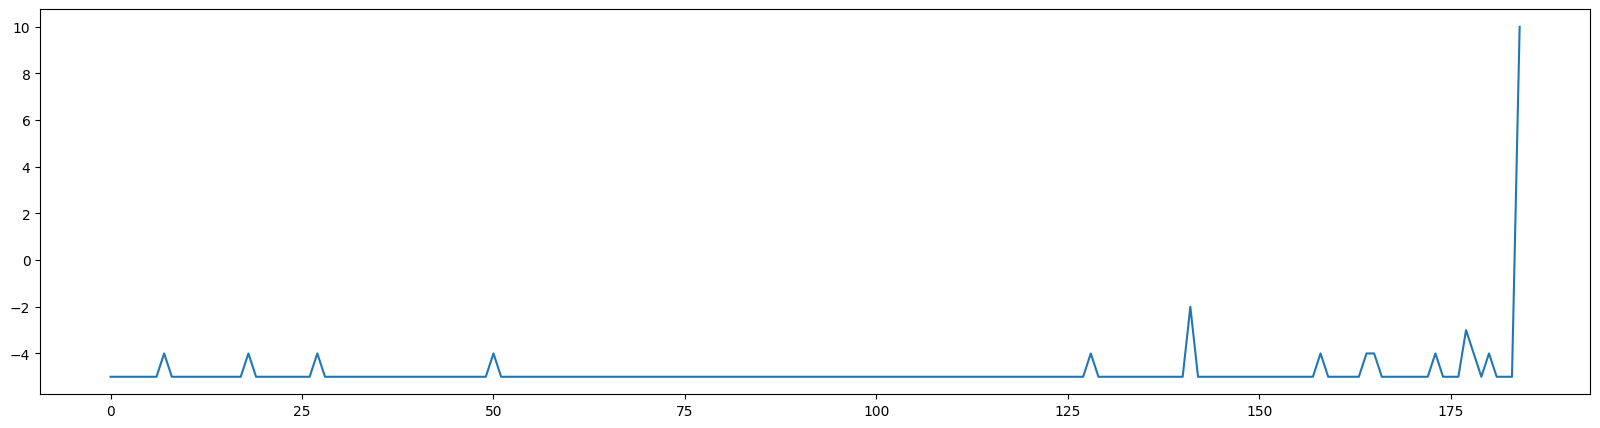

In [16]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(avg_rewards_list)), avg_rewards_list)
plt.show()

我總共跑了1840 episode才讓best reward>10，但我覺得所需耗費的時間還蠻長的，需要8-9個小時
在訓練部分，我覺得和上次的Q-Learning以及SARSA相比，PROXGAE整體感覺訓練較為穩定，reward比較不會有大幅度一直上下擺動的感覺
另外，我覺得和上次的SARSA結果相比，SARSA似乎比較常會有貼著管子邊緣過的問題，但PROXGAE這個方法似乎會飛得比較中間，比較不會膽戰心驚的通過管子，然後在下一個比較高的管子直接撞上去的問題->這可能和PROXGAE會考慮到未來有關係